In [26]:
import geopandas as gpd
import fiona
import contextily as ctx
import geopandas as gpd
import pandas as pd
from shapely import geometry
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [30]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
roads = gpd.read_file('../Geospatial/GEOSPATIAL/master-plan-2019-road-name-layer/master-plan-2019-road-name-layer.kml', driver='KML')
roads["Name"] = roads.Description.str.extract("<td>(.*?)</td>")
roads["Type"] = roads.Description.str.extract("RD_TYP_CD</th>.*?<td>(.*?)</td>")
roads = roads.drop("Description",axis=1)

planning = gpd.read_file('../Geospatial/GEOSPATIAL/subzone-census-2010/Subzone_Census2010.kml', driver='KML')
planning["SubzoneCode"] = planning.Description.str.extract("Subzone Code.*?<td>(.*?)</td>")
planning["Planning"] = planning.Description.str.extract("Planning Area Name.*?<td>(.*?)</td>")
planning["PlanningCode"] = planning.Description.str.extract("Planning Area Code.*?<td>(.*?)</td>")
planning["Region"] = planning.Description.str.extract("Region Name.*?<td>(.*?)</td>")
planning["RegionCode"] = planning.Description.str.extract("Region Code.*?<td>(.*?)</td>")
planning = planning.rename(columns={"Name":"Subzone"})
planning = planning.drop("Description",axis=1)
planning = planning[['Region', 'RegionCode', 'Planning', 'PlanningCode', 'Subzone', 'SubzoneCode', 'geometry']]

roadsm = roads.values.tolist()
planningm = planning.values.tolist()

roads = []
for road, line, rType in tqdm(roadsm):
    appeared = False
    for *details, shape in planningm:
        if line.within(shape) or line.intersects(shape):
            roads.append((road, rType, line) + tuple(details))
            appeared = True
    if not appeared:
        roads.append((road, rType, line) + ("",)*6)

roads = gpd.GeoDataFrame(roads)
roads.columns = ["Road", "Type", "geometry", "Region", "RegionCode", "Planning", "PlanningCode", "Subzone", "SubzoneCode"]

100%|██████████| 12232/12232 [00:30<00:00, 405.70it/s]


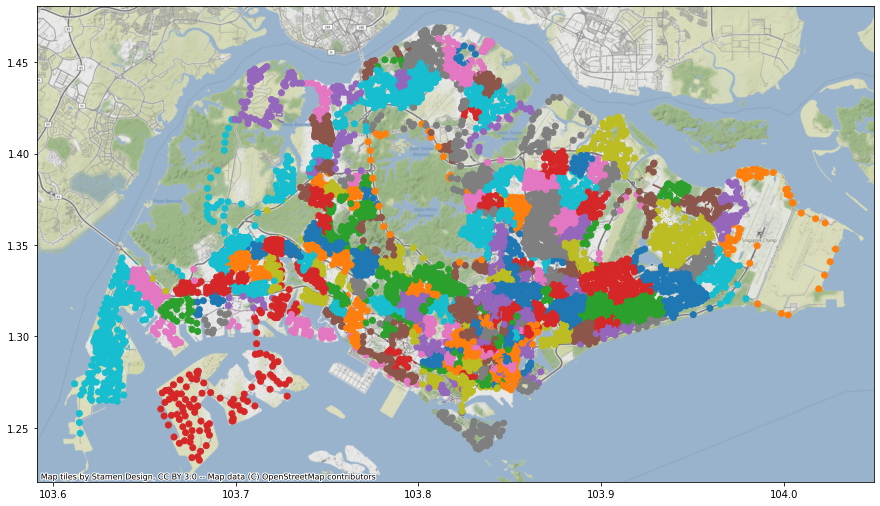

In [27]:
ax = roads[roads.Region != ""].plot(figsize=(15,15), column="Subzone")
ctx.add_basemap(ax=ax, zoom=13, crs="EPSG:4326")

In [153]:
roads.Planning.unique()

array(['SENGKANG', 'MARINE PARADE', 'KALLANG', 'MARINA EAST', 'PASIR RIS',
       'SUNGEI KADUT', 'CHOA CHU KANG', 'BUKIT MERAH', 'BUKIT PANJANG',
       'PUNGGOL', 'WESTERN WATER CATCHMENT', 'JURONG EAST', 'SELETAR',
       'TANGLIN', 'GEYLANG', 'WOODLANDS', 'QUEENSTOWN', 'BOON LAY',
       'DOWNTOWN CORE', 'MANDAI', 'BUKIT TIMAH',
       'CENTRAL WATER CATCHMENT', 'TAMPINES', 'BEDOK', 'JURONG WEST',
       'PIONEER', 'BUKIT BATOK', 'CLEMENTI', 'TUAS', 'OUTRAM', 'TENGAH',
       'YISHUN', 'ANG MO KIO', 'HOUGANG', 'SERANGOON', 'TOA PAYOH',
       'SOUTHERN ISLANDS', 'CHANGI', 'NOVENA', 'SIMPANG', 'SEMBAWANG',
       'BISHAN', 'PAYA LEBAR', 'SINGAPORE RIVER', 'MARINA SOUTH',
       'WESTERN ISLANDS', 'NEWTON', 'STRAITS VIEW', 'ORCHARD', 'ROCHOR',
       'RIVER VALLEY', 'MUSEUM', 'LIM CHU KANG', 'CHANGI BAY',
       'NORTH EASTERN ISLANDS'], dtype=object)

In [32]:
roads_filtered = roads[roads.geometry.apply(lambda x: type(x) == shapely.geometry.point.Point)]

In [50]:
pd.DataFrame(roads_filtered.geometry.apply(lambda x: x.coords[0][:2]).tolist()).to_clipboard(index=False)

In [52]:
roads_filtered.Road.value_counts()

-1    8788
0     1781
       727
Name: Road, dtype: int64

In [53]:
roads_filtered

,Road,Type,geometry,Region,RegionCode,Planning,PlanningCode,Subzone,SubzoneCode
0,-1,NaN,POINT Z (103.75235 1.43475 0.00000),NORTH REGION,NR,SUNGEI KADUT,SK,RESERVOIR VIEW,SKSZ05
1,-1,NaN,POINT Z (103.74987 1.42794 0.00000),NORTH REGION,NR,SUNGEI KADUT,SK,RESERVOIR VIEW,SKSZ05
2,-1,NaN,POINT Z (103.74758 1.42870 0.00000),NORTH REGION,NR,SUNGEI KADUT,SK,RESERVOIR VIEW,SKSZ05
3,-1,NaN,POINT Z (103.74866 1.42772 0.00000),NORTH REGION,NR,SUNGEI KADUT,SK,RESERVOIR VIEW,SKSZ05
4,-1,NaN,POINT Z (103.74952 1.42906 0.00000),NORTH REGION,NR,SUNGEI KADUT,SK,RESERVOIR VIEW,SKSZ05
...,...,...,...,...,...,...,...,...,...
12287,-1,NaN,POINT Z (103.79375 1.45941 0.00000),NORTH REGION,NR,SEMBAWANG,SB,SENOKO NORTH,SBSZ08
12289,-1,NaN,POINT Z (103.88070 1.33171 0.00000),CENTRAL REGION,CR,GEYLANG,GL,MACPHERSON,GLSZ02
12290,,NaN,POINT Z (103.87795 1.33303 0.00000),CENTRAL REGION,CR,TOA PAYOH,TP,SENNETT,TPSZ11
12292,-1,NaN,POINT Z (103.88995 1.29937 0.00000),CENTRAL REGION,CR,MARINE PARADE,MP,MOUNTBATTEN,MPSZ01


In [54]:
roads_raw = gpd.read_file('../Geospatial/GEOSPATIAL/master-plan-2019-road-name-layer/master-plan-2019-road-name-layer.kml', driver='KML')

In [57]:
roads_raw.Description[0]

'<center><table><tr><th colspan=\'2\' align=\'center\'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>FEATUREID</th> <td>-1</td> </tr><tr bgcolor=""> <th>ZORDER</th> <td></td> </tr><tr bgcolor="#E3E3F3"> <th>ANNOTATIONCLASSID</th> <td></td> </tr><tr bgcolor=""> <th>SYMBOLID</th> <td>-1</td> </tr><tr bgcolor="#E3E3F3"> <th>STATUS</th> <td>0</td> </tr><tr bgcolor=""> <th>TEXTSTRING</th> <td>KRANJI</td> </tr><tr bgcolor="#E3E3F3"> <th>FONTNAME</th> <td>Arial</td> </tr><tr bgcolor=""> <th>FONTSIZE</th> <td>51.02</td> </tr><tr bgcolor="#E3E3F3"> <th>BOLD</th> <td>0</td> </tr><tr bgcolor=""> <th>ITALIC</th> <td>0</td> </tr><tr bgcolor="#E3E3F3"> <th>UNDERLINE</th> <td>0</td> </tr><tr bgcolor=""> <th>VERTICALALIGNMENT</th> <td>3</td> </tr><tr bgcolor="#E3E3F3"> <th>HORIZONTALALIGNMENT</th> <td>0</td> </tr><tr bgcolor=""> <th>XOFFSET</th> <td>0</td> </tr><tr bgcolor="#E3E3F3"> <th>YOFFSET</th> <td>0</td> </tr><tr bgcolor=""> <th>ANGLE</th> <td>70.80654899999999</td> </tr><tr bgcolor="